In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.oriented_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Meshcat url:  http://127.0.0.1:7001/static/


In [3]:
# Draw a random sample from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = OrientedClusterRoot,
    root_node_tf = torch.eye(4)
)
torch.random.manual_seed(5)
tree = grammar.sample_tree()
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d clusters and %d boxes." % 
      (len(tree.find_nodes_by_type(OrientedCluster)),
       len(tree.find_nodes_by_type(LongBox))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

[2021-08-31 19:49:40.742] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Sampled scene with 2 clusters and 4 boxes.
Sampled tree has score 12.060009
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Super tree has 13 nodes


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


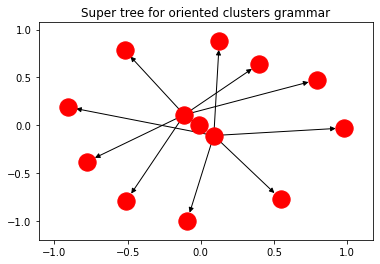

In [4]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [5]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True,
)
mip_optimized_tree = get_optimized_tree_from_mip_results(inference_results)
draw_scene_tree_contents_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip")
draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_scene_tree")

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.
Continuous variables allocated.
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
Setup time:  0.33956384658813477
Num vars:  2207
Num constraints:  8122
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Aug 31 19:49:41 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 6043 rows, 2247 columns and 41147 nonzeros
Model fingerprint: 0x7f470992
Model has 10 quadratic constraints
Variable types: 2158 continuous, 89 integer (89 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 5635 rows and 1827 columns
Presolve time: 0.10s
Presol

In [6]:
# Do NLP refinement of tree
refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=True)
refined_tree = refinement_results.refined_tree
draw_scene_tree_contents_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined_scene_tree")

NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
Success?:  True
Logfile: 

         S N O P T  7.4-1.2  (Feb 2015)
1
 
 SNMEMA EXIT 100 -- finished successfully
 SNMEMA INFO 104 -- memory requirements estimated

 
 ===>  WARNING - Column      1 of the Jacobian is empty.
 ===>  WARNING - Column      2 of the Jacobian is empty.
 ===>  WARNING - Column      3 of the Jacobian is empty.
 ===>  WARNING - Column      4 of the Jacobian is empty.
 ===>  WARNING - Column      5 of the Jacobian is empty.
 ===>  WARNING - Column      6 of the Jacobian is empty.
 ===>  WARNING - Column      7 of the Jacobian is empty.
 ===>  WARNING - Column      8 of the Jacobian is empty.
 ===>  WARNING - Column      9 of the Jacobian is empty.
 ===>  WARNING - Column     43 of the Jacobian is empty.
 ===>  WARNING - Column     44 of the Jacobian is empty.
 ===>  WARNING - Column     45 of the Jacobian is empty.
 ===>  WARNING - Column     55 of the Jacobian is empt

In [7]:
try:
    mip_optimized_tree.score()
except ValueError as e:
    print("MIP optimized tree wasn't happy, as expected: %s" % str(e))

print(refined_tree.score())

MIP optimized tree wasn't happy, as expected: ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f8144cadcf8>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f8144cb8ef0>: ', 'Child illegal rotated from parent: tensor([ 0.6976, -0.7165, -0.0000]) vs tensor([1., 0., 0.]), error of 45.765553 deg')
tensor([12.0600])


In [24]:
# Now try to do MCMC on the parsed tree
sampled_trees = do_fixed_structure_mcmc(grammar, tree, num_samples=100, verbose=True)

0: Accept rate 0.000000
New score 12.060009, old score 12.060009, alpha 1.000000
1: Accept rate 0.500000
New score 12.060009, old score 12.060009, alpha 1.000000
2: Accept rate 0.666667
New score 12.060009, old score 12.060009, alpha 1.000000
3: Accept rate 0.750000
New score 12.060009, old score 12.060009, alpha 1.000000
4: Accept rate 0.800000
New score 12.060009, old score 12.060009, alpha 1.000000
5: Accept rate 0.833333
6: Accept rate 0.714286
Unexpected ValueError:  ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f80533809b0>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f8053420240>: ', 'Child illegal rotated from parent: tensor([ 0.9927, -0.1210,  0.0000]) vs tensor([1., 0., 0.]), error of 6.949228 deg')
7: Accept rate 0.625000
New score 12.060009, old score 12.060009, alpha 1.000000
8: Accept rate 0.666667
Unexpected ValueError:  ('Parent <spatial_scene_grammars_examples.oriented_clusters

Unexpected ValueError:  ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f8053469898>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f8053469fd0>: ', 'Child illegal rotated from parent: tensor([0.9953, 0.0971, 0.0000]) vs tensor([1., 0., 0.]), error of 5.572633 deg')
44: Accept rate 0.777778
New score 12.060009, old score 12.060009, alpha 1.000000
45: Accept rate 0.782609
46: Accept rate 0.765957
Unexpected ValueError:  ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f80534a0eb8>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f80534a0e48>: ', 'Child illegal rotated from parent: tensor([0.9560, 0.2935, 0.0000]) vs tensor([1., 0., 0.]), error of 17.068157 deg')
47: Accept rate 0.750000
Unexpected ValueError:  ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f80534a08

In [26]:
for sample_k, sampled_tree in enumerate(sampled_trees[::5]):
    draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sampled/%d" % sample_k)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You can open the visu